In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
from fr_utils import *
from inception_blocks import *
from imageio import imread
from PIL import Image
import matplotlib.pyplot as plt


%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(threshold=np.nan)

Using TensorFlow backend.


In [2]:
FRmodel= faceRecoModel(input_shape=(3, 96, 96))

In [3]:
print(FRmodel.layers[151].name)

average_pooling2d_4


In [4]:
def triplet_loss(y_true, y_pred, alpha = 0.2):

    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    # distance between the anchor and the positive, you will need to sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
    # distance between the anchor and the negative, you will need to sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    # subtract the two previous distances and add alpha.
    basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
    # maximum of basic_loss and 0.0
    loss = tf.reduce_sum(tf.maximum(basic_loss,0))

    return loss

In [5]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
load_weights_from_FaceNet(FRmodel)

In [6]:
# Fill database here with image encodings
database = {}
database['Greg'] = img_to_encoding("images/greg_positive.jpg", FRmodel)
database['Maxim'] = img_to_encoding("images/maxim_positive.jpg", FRmodel)


In [7]:
def encode_image(image_path, model):
    return img_to_encoding(image_path, model)

In [8]:
def verify(image_path, identity, database, model, threshold=0.7):
    
    encoding = img_to_encoding(image_path, model)

    # Compute distance with identity's image 
    dist = np.linalg.norm(encoding-database[identity])
    
    if dist < threshold:
        print("It's " + str(identity) + ", identity confirmed. Distance is " + str(dist))
        identity_confirmed = True
    else:
        print("It's not " + str(identity) + ", identity denied. Distance is " + str(dist))
        identity_confirmed = False


    return dist, identity_confirmed

In [9]:
verify("images/maxim_anchor.jpg", "Greg", database, FRmodel)

It's not Greg, identity denied. Distance is 0.91445863


(0.91445863, False)

In [10]:
def who_is_it(image_path, database, model):

    encoding = encode_image(image_path, model)

    min_dist = 100

    for (name, db_enc) in database.items():

        # L2 distance 
        dist = np.linalg.norm(encoding-db_enc)

        if dist < min_dist:
            min_dist = dist
            identity = name


    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("It's " + str(identity) + ", the distance is " + str(min_dist))

    return min_dist, identity

In [11]:
def layer_n_output_3D(n, image_path):
    get_nth_layer_output = K.function([FRmodel.layers[0].input],
                                     [FRmodel.layers[n].output])
    
    matrix1 = cv2.imread(image_path, 1)
    matrix = matrix1[...,::-1]
    matrix = np.around(np.transpose(matrix, (2, 0, 1))/255.0, decimals=12)
    matrix = np.array([matrix])
    
    pre_output = get_nth_layer_output([matrix])[0]
    
    output = pre_output[0]
    
    return output

In [12]:
def reshape_layer_output(layer_n_output):
    return np.moveaxis(layer_n_output, 0, -1)

In [13]:
def normalize_reshaped_layer_output(reshaped_layer_n_output):
    return np.linalg.norm(reshaped_layer_n_output, axis=-1)

In [14]:
def compare_two_faces(face_path_1, face_path_2, layer_num):
    face_1_output_3D = layer_n_output_3D(layer_num, face_path_1)
    face_2_output_3D = layer_n_output_3D(layer_num, face_path_2)
    
    reshapen_face_1 = reshape_layer_output(face_1_output_3D)
    reshapen_face_2 = reshape_layer_output(face_2_output_3D)
    
    normalized_face_1 = normalize_reshaped_layer_output(reshapen_face_1)
    normalized_face_2 = normalize_reshaped_layer_output(reshapen_face_2)
    
    #difference_matrix = normalized_face_1 - normalized_face_2
    difference_matrix = np.linalg.norm(reshapen_face_1 - reshapen_face_2, axis=-1)
    
    return abs(difference_matrix)

In [15]:
print((compare_two_faces("images/greg_anchor.jpg", "images/greg_positive.jpg", 101)))

[[1.7807927 3.3000193 3.0165348 3.0588722 2.5913117 1.8523998]
 [1.8212085 2.5752337 3.0649781 3.3698268 2.7493246 2.466854 ]
 [2.4606428 3.2083251 3.8953753 3.845895  2.993902  2.521517 ]
 [2.5460072 3.1193457 3.7706046 3.383678  3.0645778 2.5266557]
 [2.280741  2.30233   2.9325964 3.1266005 3.4736238 2.6822867]
 [2.1686175 2.3558335 2.5483634 2.925761  2.5132563 2.9581833]]


In [72]:
def tensordot(matrix_1, matrix_2):
    return np.einsum("ijk,ijk->ij", matrix_1, matrix_2)

In [84]:
def compare_two_faces_with_dot(face_path_1, face_path_2, layer_num):
    face_1_output_3D = layer_n_output_3D(layer_num, face_path_1)
    face_2_output_3D = layer_n_output_3D(layer_num, face_path_2)
    
    reshapen_face_1 = reshape_layer_output(face_1_output_3D)
    reshapen_face_2 = reshape_layer_output(face_2_output_3D)
    
    #print(reshapen_face_1)
   # print(reshapen_face_2)
    
    similarity_matrix = tensordot(reshapen_face_1, reshapen_face_2)
    
    return abs(similarity_matrix)
    

In [86]:
print(compare_two_faces_with_dot("images/greg_anchor.jpg", "images/greg_positive.jpg", 101))

[[33.539215 41.068886 34.947735 31.90503  46.18957  33.605995]
 [25.029896 33.019917 44.889004 31.456438 28.470592 36.5226  ]
 [45.719887 45.149002 58.699486 62.207584 39.751827 30.037481]
 [36.824326 35.15356  66.94512  63.033806 34.3183   30.014015]
 [22.032764 16.435068 37.803158 41.611    20.880817 23.135029]
 [25.896494 22.996176 28.335922 37.026775 32.849895 33.846333]]


In [67]:
def overlay_difference_colors(positive_image_path, anchor_image_path, difference_matrix):
    
    positive_matrix = cv2.imread(positive_image_path)
    anchor_matrix = cv2.imread(anchor_image_path)
    
    num_sectors = len(difference_matrix[0])
    num_pixels_in_row = len(positive_matrix[0])
    
    ten_percentile = np.percentile(difference_matrix, 10)
    twentyfive_percentile = np.percentile(difference_matrix, 25)
    forty_percentile = np.percentile(difference_matrix, 40)
    sixty_percentile = np.percentile(difference_matrix, 60)
    seventyfive_percentile = np.percentile(difference_matrix, 75)
    ninety_percentile = np.percentile(difference_matrix, 90)
    
    for i in range(num_sectors):
        for j in range(num_sectors):
            
            #cur_section = anchor_matrix[np.ceiling((((i-1)/num_sectors))*num_pixels_in_row) + 1 : np.ceiling((((i/num_sectors))*num_pixels_in_row))][np.ceiling((((j-1)/num_sectors))*num_pixels_in_row) + 1 : np.ceiling((((j/num_sectors))*num_pixels_in_row))]
            cur_difference = difference_matrix[i][j]
            
            low_i = int(np.ceil(((i)/num_sectors) * num_pixels_in_row))
            high_i = int(np.ceil((i+1/num_sectors) * num_pixels_in_row)) - 1
            
            low_j = int(np.ceil(((j)/num_sectors) * num_pixels_in_row))
            high_j = int(np.ceil((j+1/num_sectors) * num_pixels_in_row)) - 1
            
            if cur_difference <= ten_percentile:
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = 200
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = anchor_matrix[low_i : high_i, low_j : high_j, 0] / 1.15
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = anchor_matrix[low_i : high_i, low_j : high_j, 2] / 1.15        
            elif cur_difference <= twentyfive_percentile:
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = 100
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = anchor_matrix[low_i : high_i, low_j : high_j, 0] / 1.5
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = anchor_matrix[low_i : high_i, low_j : high_j, 2] / 1.5
                #print("25")
            elif cur_difference <= forty_percentile:
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = 50
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = anchor_matrix[low_i : high_i, low_j : high_j, 0] / 2
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = anchor_matrix[low_i : high_i, low_j : high_j, 2] / 2
                #print("40")
            elif cur_difference <= sixty_percentile:
                a = None
            elif cur_difference <= seventyfive_percentile:
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = 50
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = anchor_matrix[low_i : high_i, low_j : high_j, 1] / 2
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = anchor_matrix[low_i : high_i, low_j : high_j, 2] / 2
                #print("90")
            elif cur_difference <= ninety_percentile:
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = 100
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = anchor_matrix[low_i : high_i, low_j : high_j, 1] / 1.5
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = anchor_matrix[low_i : high_i, low_j : high_j, 2] / 1.5
                #print("90")
            else:
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = 200
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = anchor_matrix[low_i : high_i, low_j : high_j, 1] / 1.15
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = anchor_matrix[low_i : high_i, low_j : high_j, 2] / 1.15
                #print("90")
                
    return anchor_matrix, positive_matrix

In [92]:
def overlay_difference_colors_dot(positive_image_path, anchor_image_path, similarity_matrix):
    
    positive_matrix = cv2.imread(positive_image_path)
    anchor_matrix = cv2.imread(anchor_image_path)
    
    num_sectors = len(similarity_matrix[0])
    num_pixels_in_row = len(positive_matrix[0])
    
    ten_percentile = np.percentile(similarity_matrix, 10)
    twentyfive_percentile = np.percentile(similarity_matrix, 25)
    forty_percentile = np.percentile(similarity_matrix, 40)
    sixty_percentile = np.percentile(similarity_matrix, 60)
    seventyfive_percentile = np.percentile(similarity_matrix, 75)
    ninety_percentile = np.percentile(similarity_matrix, 90)
    
    for i in range(num_sectors):
        for j in range(num_sectors):
            
            #cur_section = anchor_matrix[np.ceiling((((i-1)/num_sectors))*num_pixels_in_row) + 1 : np.ceiling((((i/num_sectors))*num_pixels_in_row))][np.ceiling((((j-1)/num_sectors))*num_pixels_in_row) + 1 : np.ceiling((((j/num_sectors))*num_pixels_in_row))]
            cur_difference = similarity_matrix[i][j]
            
            low_i = int(np.ceil(((i)/num_sectors) * num_pixels_in_row))
            high_i = int(np.ceil((i+1/num_sectors) * num_pixels_in_row)) - 1
            
            low_j = int(np.ceil(((j)/num_sectors) * num_pixels_in_row))
            high_j = int(np.ceil((j+1/num_sectors) * num_pixels_in_row)) - 1
            
            if cur_difference <= ten_percentile:
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = 200
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = 0 #anchor_matrix[low_i : high_i, low_j : high_j, 0] / 1.15
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = 0 #anchor_matrix[low_i : high_i, low_j : high_j, 2] / 1.15        
            elif cur_difference <= twentyfive_percentile:
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = 100
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = 0 #anchor_matrix[low_i : high_i, low_j : high_j, 0] / 1.5
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = 0 #anchor_matrix[low_i : high_i, low_j : high_j, 2] / 1.5
                #print("25")
            elif cur_difference <= forty_percentile:
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = 50
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = 0 #anchor_matrix[low_i : high_i, low_j : high_j, 0] / 2
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = 0 #anchor_matrix[low_i : high_i, low_j : high_j, 2] / 2
                #print("40")
            elif cur_difference <= sixty_percentile:
                a = None
            elif cur_difference <= seventyfive_percentile:
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = 50
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = 0 #anchor_matrix[low_i : high_i, low_j : high_j, 1] / 2
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = 0 #anchor_matrix[low_i : high_i, low_j : high_j, 2] / 2
                #print("90")
            elif cur_difference <= ninety_percentile:
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = 100
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = 0 #anchor_matrix[low_i : high_i, low_j : high_j, 1] / 1.5
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = 0 #anchor_matrix[low_i : high_i, low_j : high_j, 2] / 1.5
                #print("90")
            else:
                anchor_matrix[low_i : high_i, low_j : high_j, 1] = 200
                anchor_matrix[low_i : high_i, low_j : high_j, 0] = 0 #anchor_matrix[low_i : high_i, low_j : high_j, 1] / 1.15
                anchor_matrix[low_i : high_i, low_j : high_j, 2] = 0 #anchor_matrix[low_i : high_i, low_j : high_j, 2] / 1.15
                #print("90")
                
    return anchor_matrix, positive_matrix

In [ ]:
greg_anchor_mat, greg_pos_mat = overlay_difference_colors("images/greg_positive.jpg", "images/greg_anchor.jpg", compare_two_faces("images/greg_positive.jpg", "images/greg_anchor.jpg", 101))
img = Image.fromarray(greg_anchor_mat, 'RGB')
plt.imshow(img)


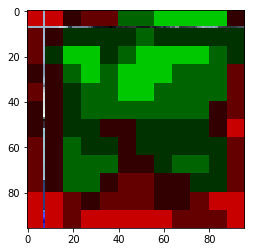

In [96]:
greg_anchor_mat, greg_pos_mat = overlay_difference_colors_dot("images/greg_positive.jpg", "images/greg_anchor.jpg", compare_two_faces_with_dot("images/greg_positive.jpg", "images/greg_anchor.jpg", 50))
img = Image.fromarray(greg_anchor_mat, 'RGB')
plt.imshow(img)

In [ ]:
def iterate_through_layers(positive_image_path, anchor_image_path, num_layers=151):
    
    for i in range(1, num_layers + 1):
        
        difference_matrix = compare_two_faces(positive_image_path, anchor_image_path, i)
        anchor_matrix, positive_matrix = overlay_difference_colors(positive_image_path, anchor_image_path, difference_matrix)
        
        img = Image.fromarray(anchor_matrix)
        plt.figure()
        plt.imshow(img)
        print(FRmodel.layers[i].name +": " + str(i))
        plt.show()

In [ ]:
#iterate_through_layers("images/greg_positive.jpg", "images/greg_anchor.jpg")

In [ ]:
#iterate_through_layers("images/greg_positive.jpg", "images/maxim_anchor.jpg")

In [102]:
def iterate_through_layers_dot(positive_image_path, anchor_image_path, num_layers=151):
    for i in range(1, num_layers+1):
        
        similarity_matrix = compare_two_faces_with_dot(positive_image_path, anchor_image_path, i)
        anchor_matrix, positive_matrix = overlay_difference_colors_dot(positive_image_path, anchor_image_path, similarity_matrix)
        
        img = Image.fromarray(anchor_matrix)
        plt.figure()
        plt.imshow(img)
        print(FRmodel.layers[i].name + ": " + str(i))
        plt.show()

zero_padding2d_1: 1


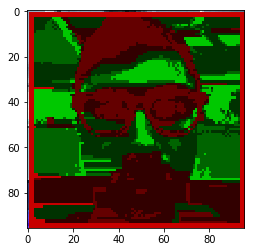

conv1: 2


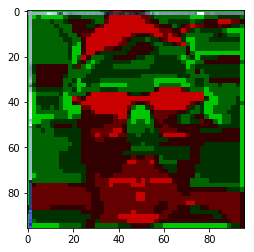

bn1: 3


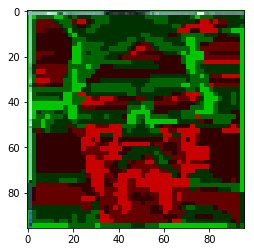

activation_1: 4


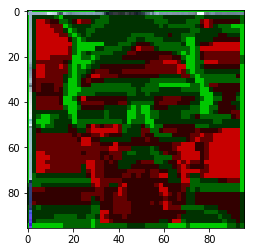

zero_padding2d_2: 5


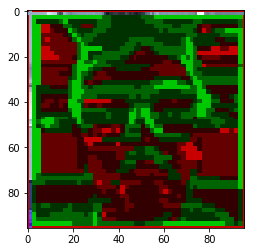

max_pooling2d_1: 6


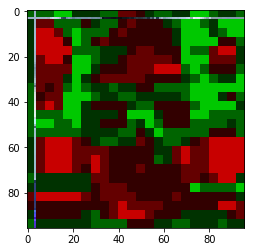

conv2: 7


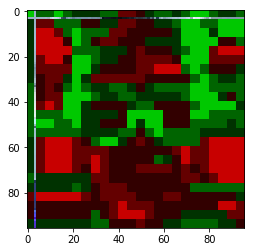

bn2: 8


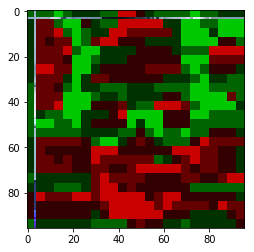

activation_2: 9


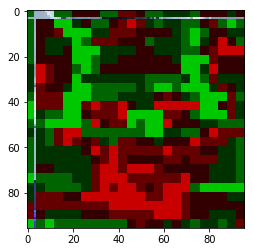

zero_padding2d_3: 10


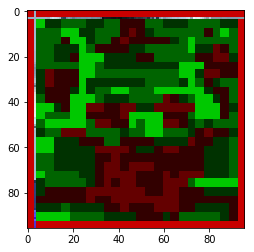

conv3: 11


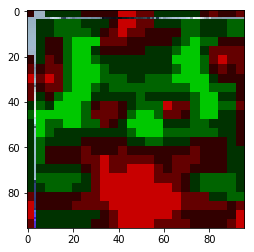

bn3: 12


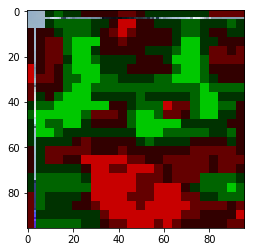

activation_3: 13


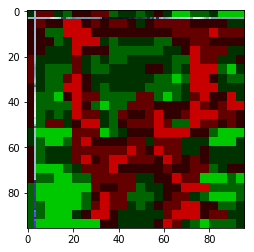

zero_padding2d_4: 14


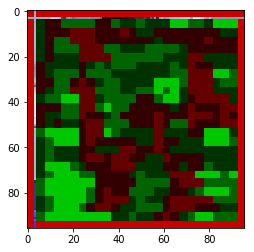

max_pooling2d_2: 15


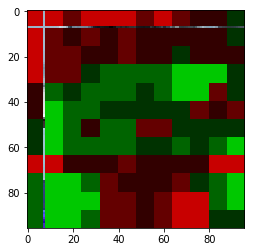

inception_3a_3x3_conv1: 16


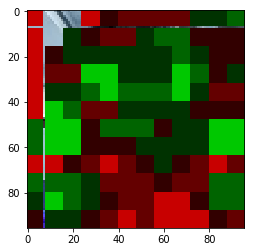

inception_3a_5x5_conv1: 17


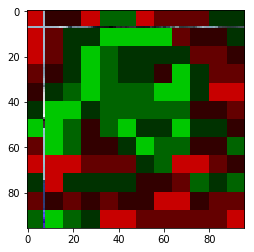

inception_3a_3x3_bn1: 18


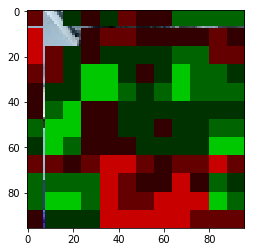

inception_3a_5x5_bn1: 19


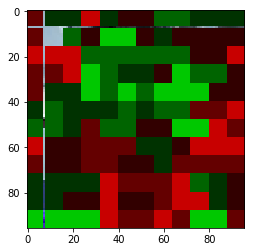

activation_4: 20


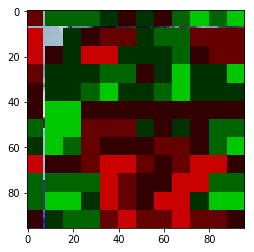

activation_6: 21


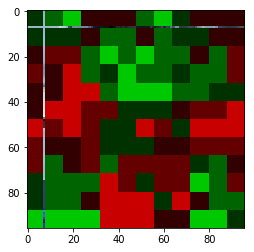

max_pooling2d_3: 22


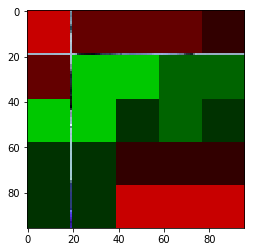

zero_padding2d_5: 23


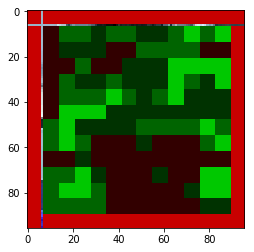

zero_padding2d_6: 24


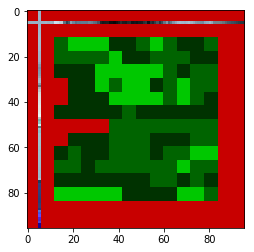

inception_3a_pool_conv: 25


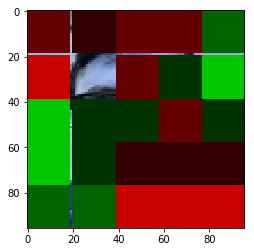

inception_3a_3x3_conv2: 26


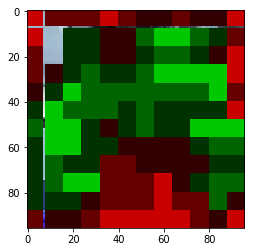

inception_3a_5x5_conv2: 27


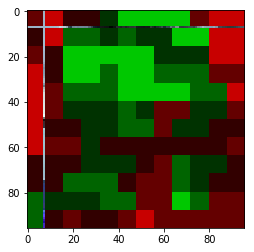

inception_3a_pool_bn: 28


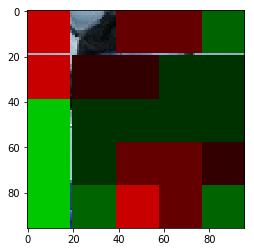

inception_3a_1x1_conv: 29


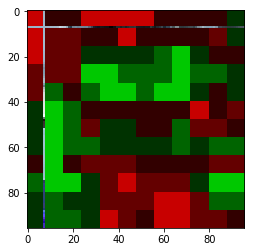

inception_3a_3x3_bn2: 30


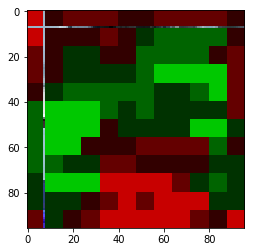

inception_3a_5x5_bn2: 31


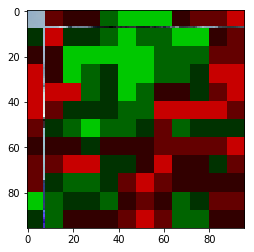

activation_8: 32


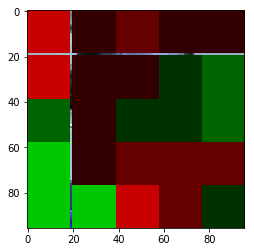

inception_3a_1x1_bn: 33


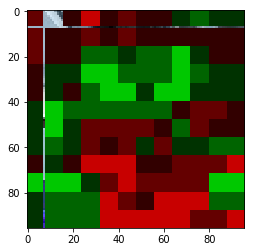

activation_5: 34


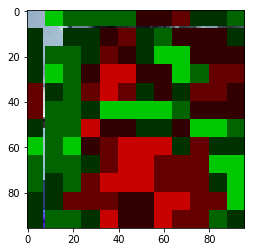

activation_7: 35


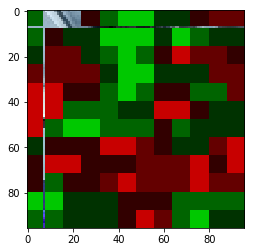

zero_padding2d_7: 36


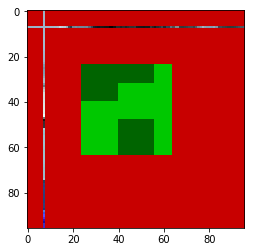

activation_9: 37


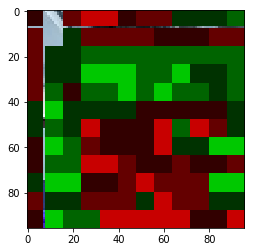

inception_1a: 38


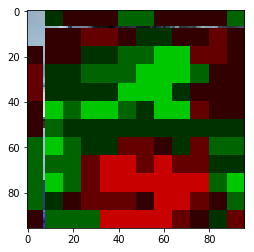

inception_3b_3x3_conv1: 39


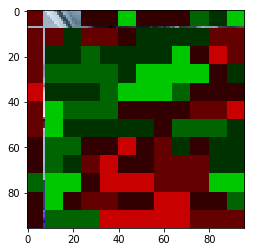

inception_3b_5x5_conv1: 40


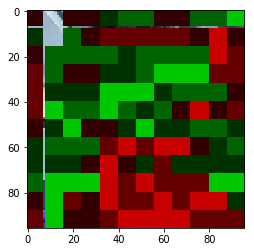

inception_3b_3x3_bn1: 41


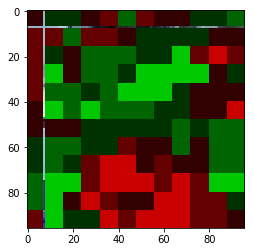

inception_3b_5x5_bn1: 42


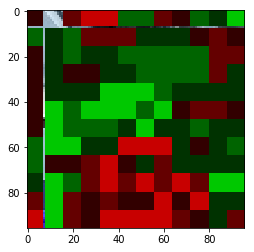

activation_10: 43


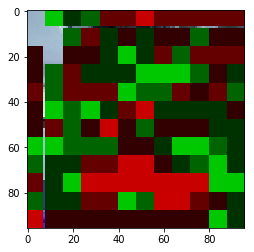

activation_12: 44


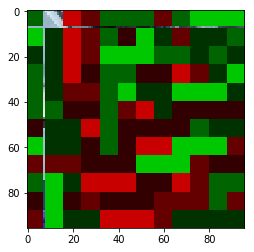

average_pooling2d_1: 45


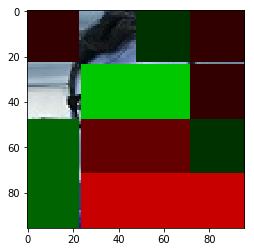

zero_padding2d_8: 46


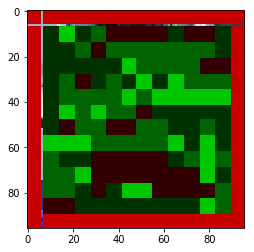

zero_padding2d_9: 47


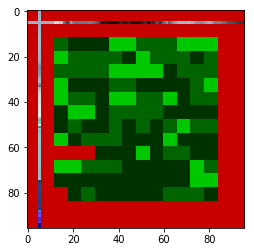

inception_3b_pool_conv: 48


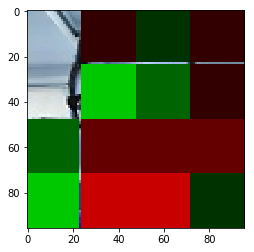

inception_3b_3x3_conv2: 49


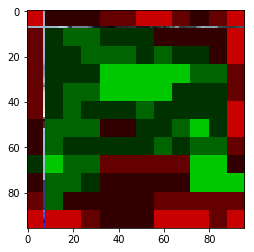

inception_3b_5x5_conv2: 50


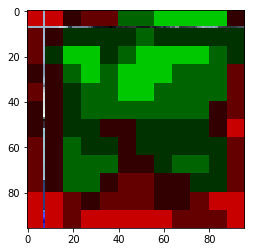

inception_3b_pool_bn: 51


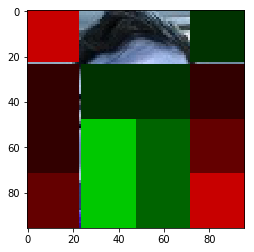

inception_3b_1x1_conv: 52


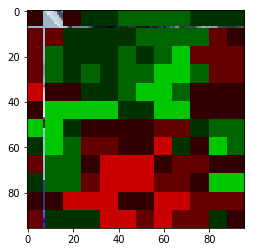

inception_3b_3x3_bn2: 53


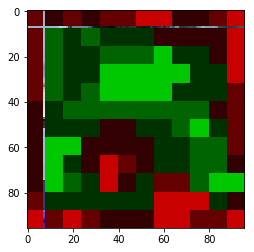

inception_3b_5x5_bn2: 54


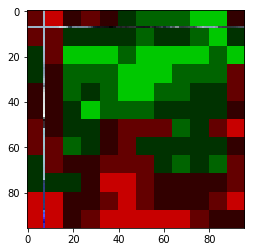

activation_14: 55


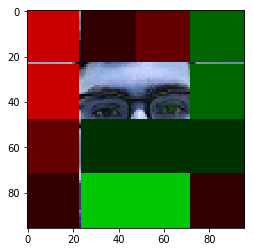

inception_3b_1x1_bn: 56


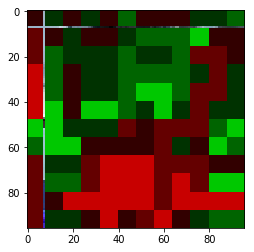

activation_11: 57


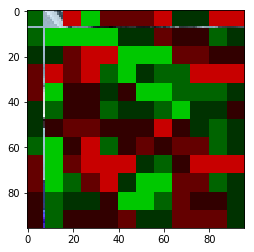

activation_13: 58


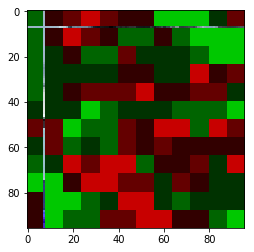

zero_padding2d_10: 59


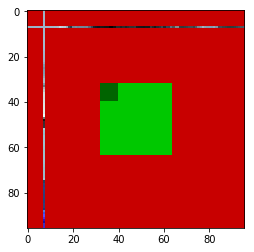

activation_15: 60


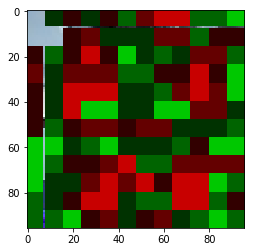

inception_1b: 61


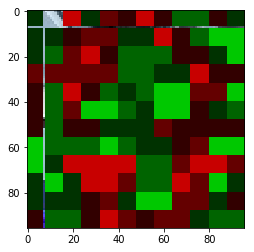

inception_3c_3x3_conv1: 62


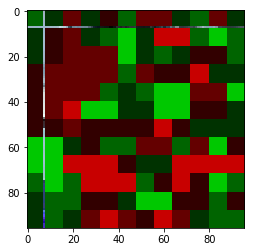

inception_3c_5x5_conv1: 63


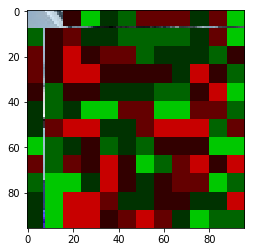

inception_3c_3x3_bn1: 64


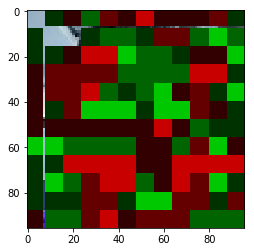

inception_3c_5x5_bn1: 65


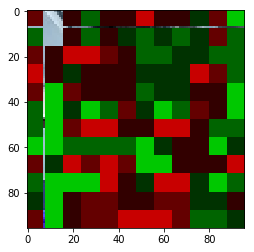

activation_16: 66


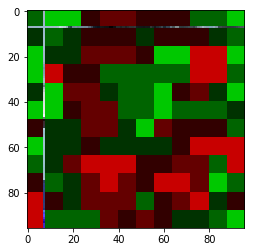

activation_18: 67


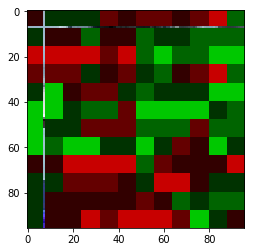

zero_padding2d_11: 68


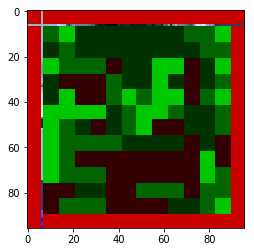

zero_padding2d_12: 69


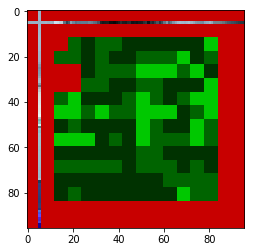

inception_3c_3x3_conv2: 70


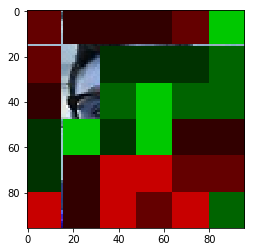

inception_3c_5x5_conv2: 71


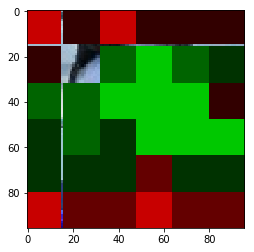

inception_3c_3x3_bn2: 72


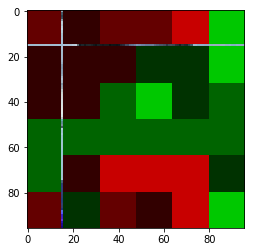

inception_3c_5x5_bn2: 73


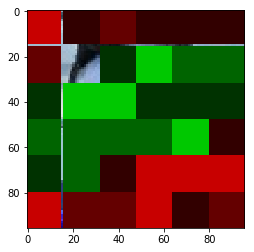

max_pooling2d_4: 74


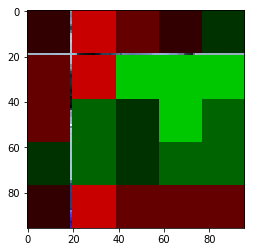

activation_17: 75


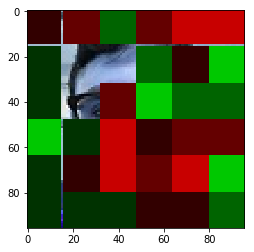

activation_19: 76


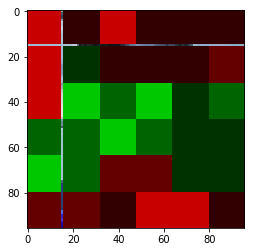

zero_padding2d_13: 77


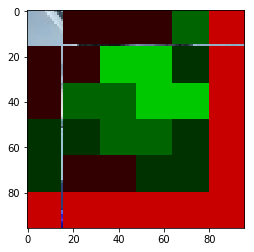

inception_1c: 78


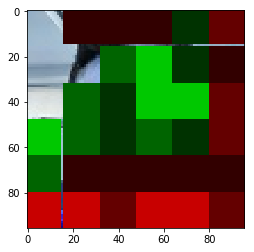

inception_4a_3x3_conv1: 79


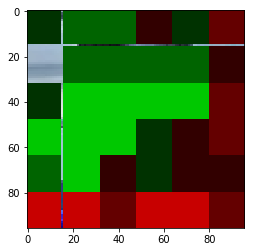

inception_4a_5x5_conv1: 80


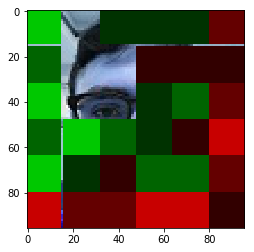

inception_4a_3x3_bn1: 81


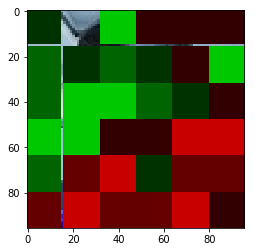

inception_4a_5x5_bn1: 82


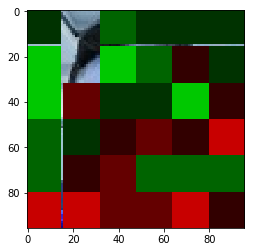

activation_20: 83


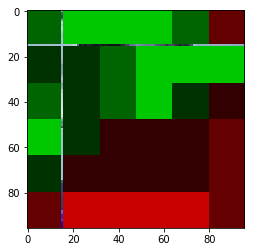

activation_22: 84


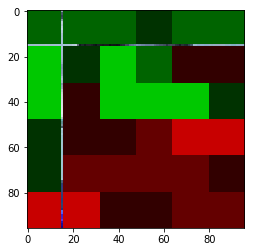

average_pooling2d_2: 85


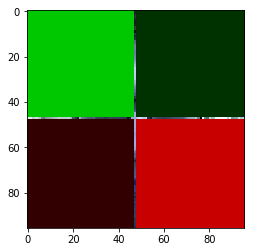

zero_padding2d_14: 86


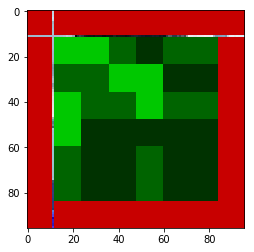

zero_padding2d_15: 87


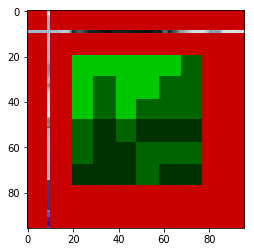

inception_4a_pool_conv: 88


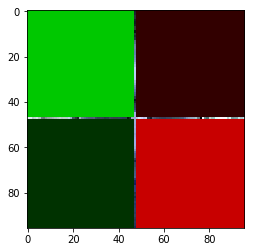

inception_4a_3x3_conv2: 89


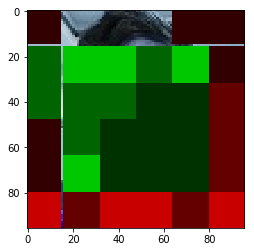

inception_4a_5x5_conv2: 90


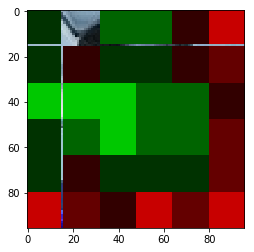

inception_4a_pool_bn: 91


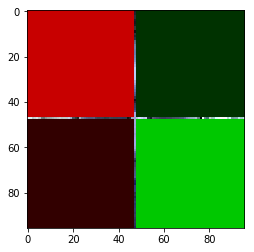

inception_4a_1x1_conv: 92


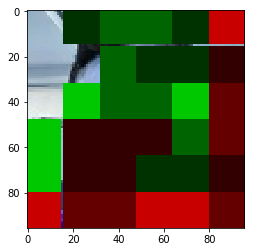

inception_4a_3x3_bn2: 93


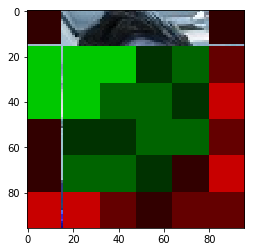

inception_4a_5x5_bn2: 94


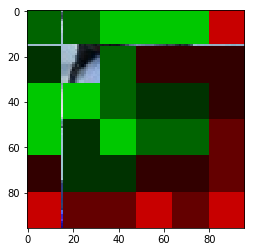

activation_24: 95


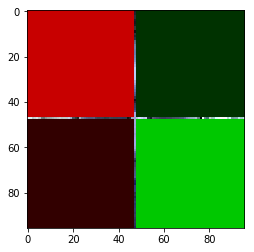

inception_4a_1x1_bn: 96


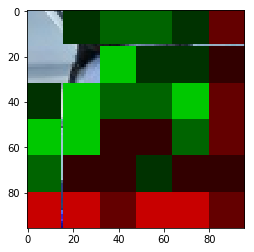

activation_21: 97


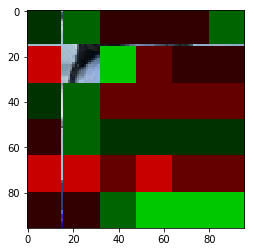

activation_23: 98


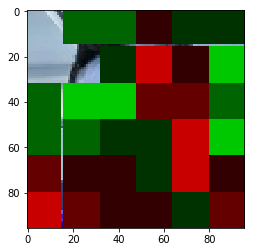

zero_padding2d_16: 99


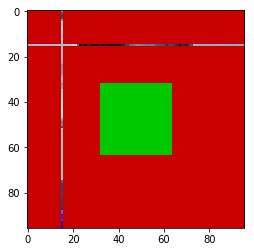

activation_25: 100


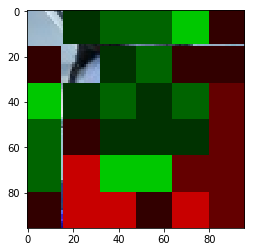

inception_2a: 101


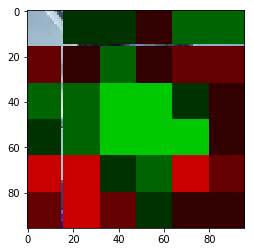

inception_4e_3x3_conv1: 102


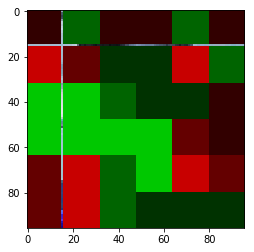

inception_4e_5x5_conv1: 103


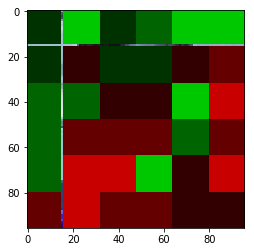

inception_4e_3x3_bn1: 104


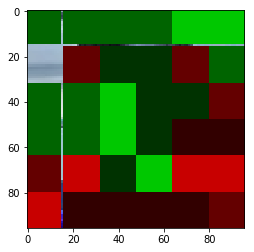

inception_4e_5x5_bn1: 105


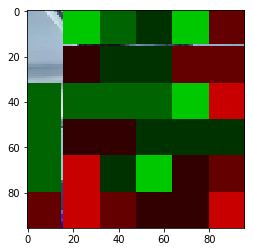

activation_26: 106


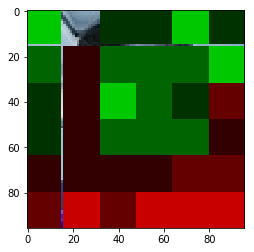

activation_28: 107


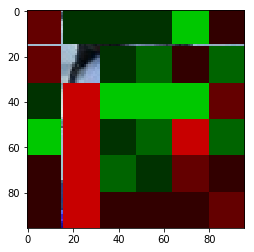

zero_padding2d_17: 108


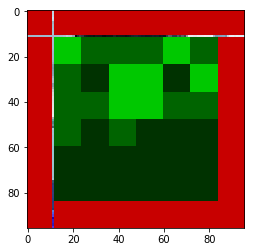

zero_padding2d_18: 109


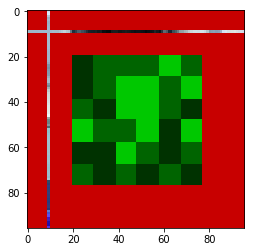

inception_4e_3x3_conv2: 110


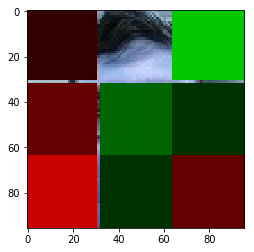

inception_4e_5x5_conv2: 111


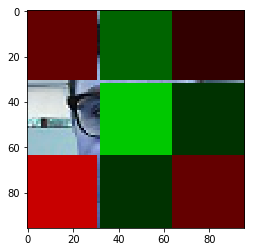

inception_4e_3x3_bn2: 112


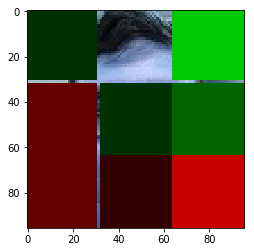

inception_4e_5x5_bn2: 113


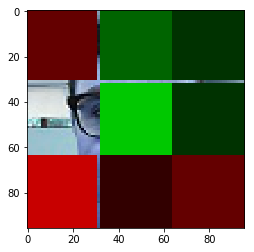

max_pooling2d_5: 114


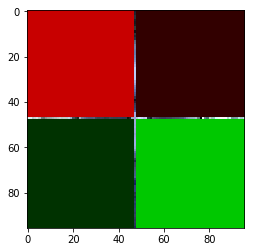

activation_27: 115


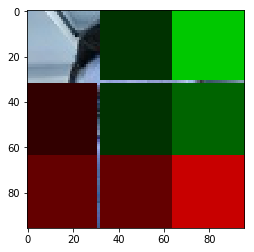

activation_29: 116


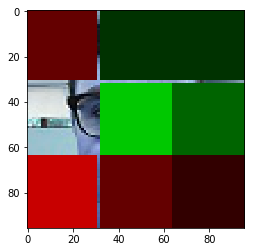

zero_padding2d_19: 117


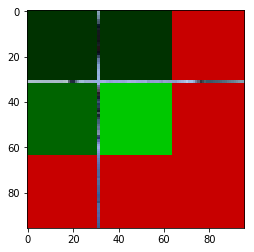

inception_2b: 118


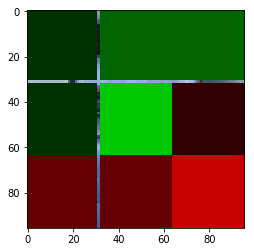

inception_5a_3x3_conv1: 119


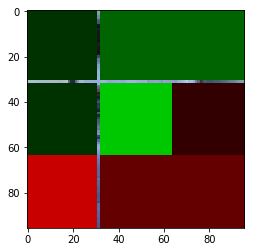

inception_5a_3x3_bn1: 120


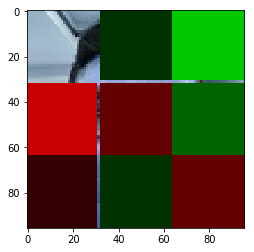

activation_30: 121


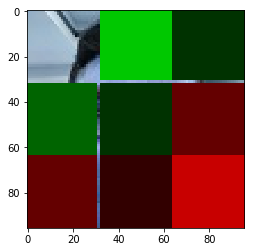

average_pooling2d_3: 122


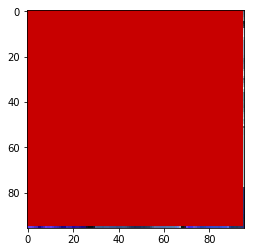

zero_padding2d_20: 123


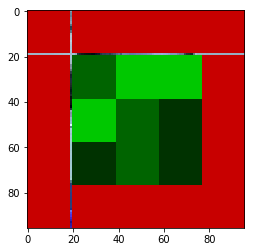

inception_5a_pool_conv: 124


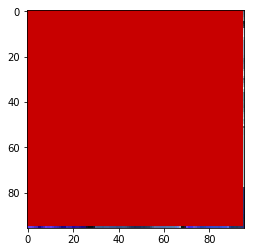

inception_5a_3x3_conv2: 125


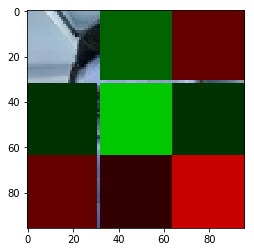

inception_5a_pool_bn: 126


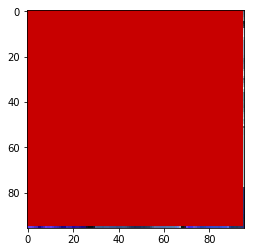

inception_5a_1x1_conv: 127


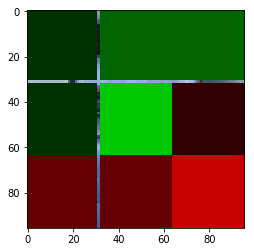

inception_5a_3x3_bn2: 128


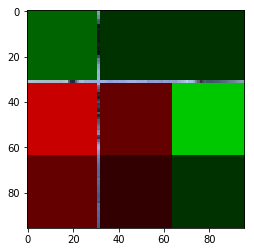

activation_32: 129


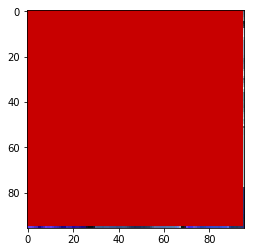

inception_5a_1x1_bn: 130


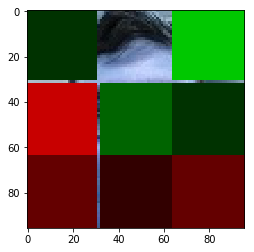

activation_31: 131


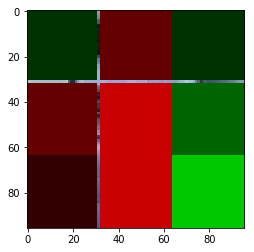

zero_padding2d_21: 132


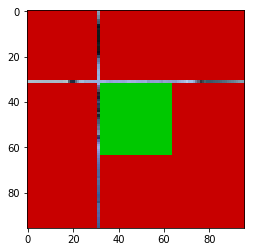

activation_33: 133


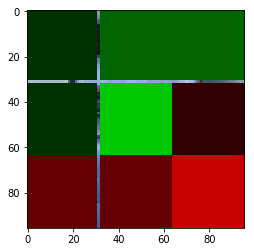

inception_3a: 134


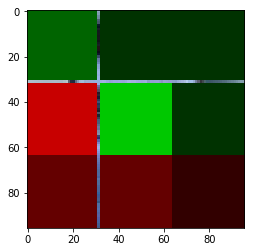

inception_5b_3x3_conv1: 135


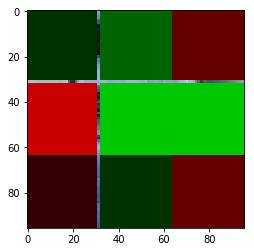

inception_5b_3x3_bn1: 136


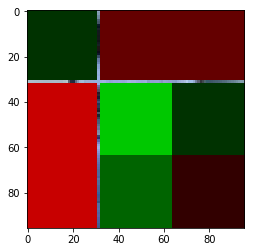

activation_34: 137


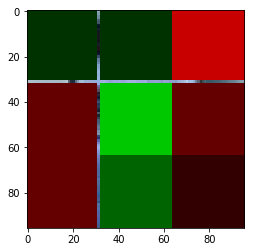

max_pooling2d_6: 138


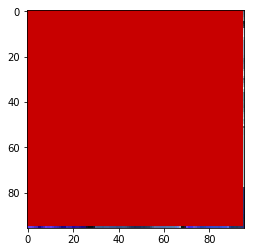

zero_padding2d_22: 139


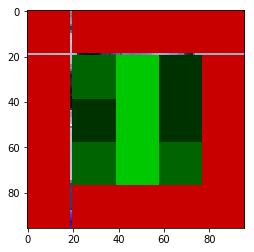

inception_5b_pool_conv: 140


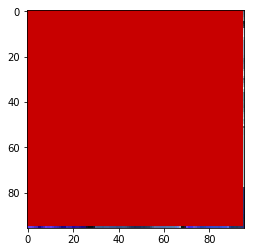

inception_5b_3x3_conv2: 141


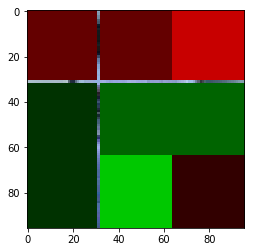

inception_5b_pool_bn: 142


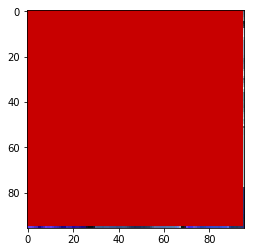

inception_5b_1x1_conv: 143


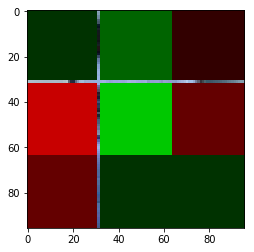

inception_5b_3x3_bn2: 144


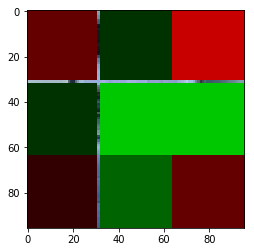

activation_36: 145


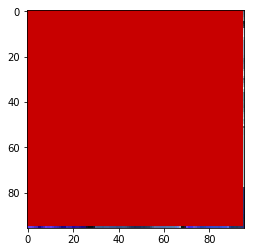

inception_5b_1x1_bn: 146


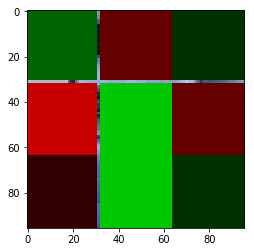

activation_35: 147


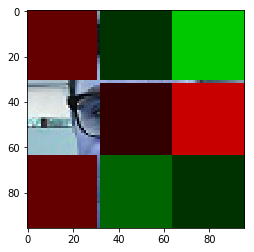

zero_padding2d_23: 148


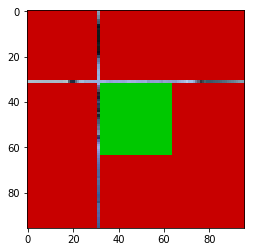

activation_37: 149


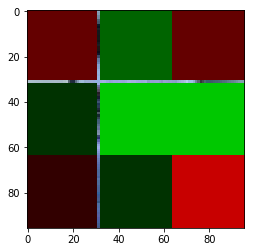

inception_3b: 150


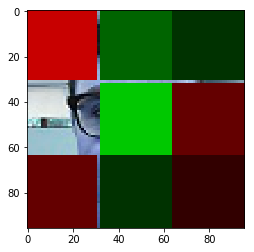

average_pooling2d_4: 151


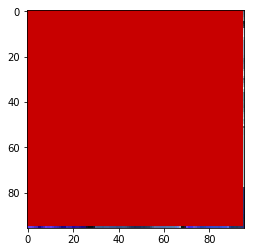

In [103]:
iterate_through_layers_dot("images/greg_positive.jpg", "images/greg_anchor.jpg")

zero_padding2d_1: 1


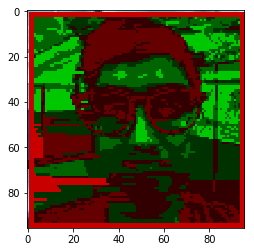

conv1: 2


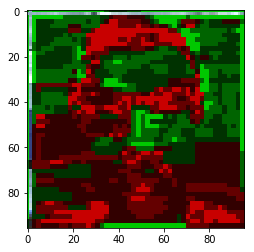

bn1: 3


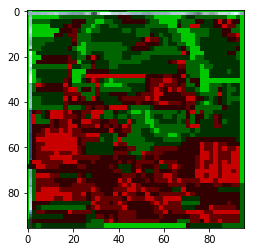

activation_1: 4


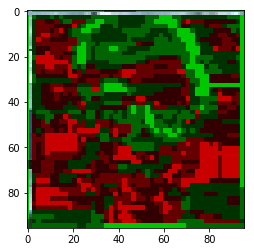

zero_padding2d_2: 5


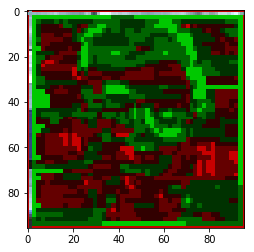

max_pooling2d_1: 6


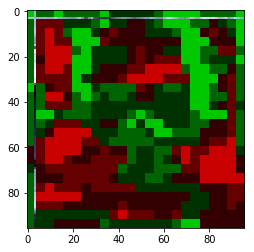

conv2: 7


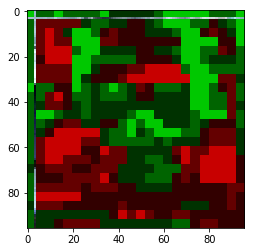

bn2: 8


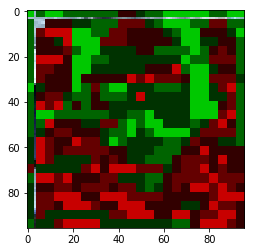

activation_2: 9


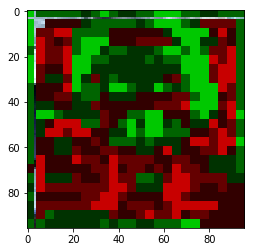

zero_padding2d_3: 10


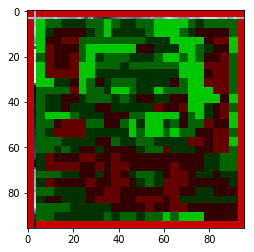

conv3: 11


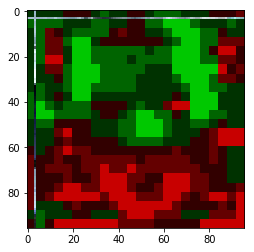

bn3: 12


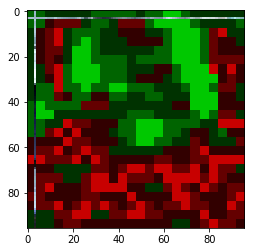

activation_3: 13


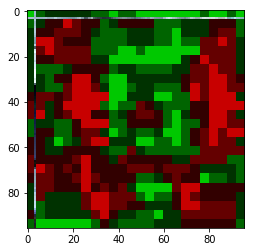

zero_padding2d_4: 14


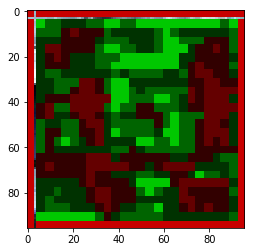

max_pooling2d_2: 15


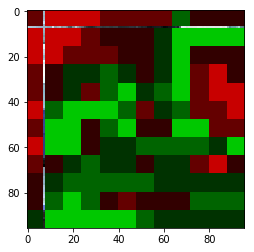

inception_3a_3x3_conv1: 16


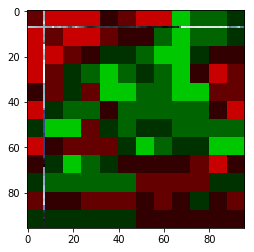

inception_3a_5x5_conv1: 17


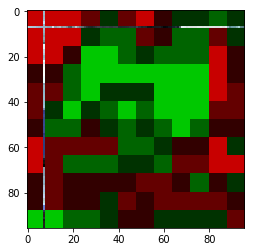

inception_3a_3x3_bn1: 18


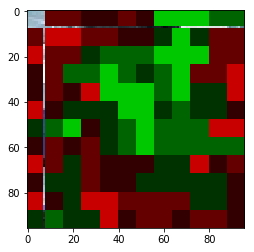

inception_3a_5x5_bn1: 19


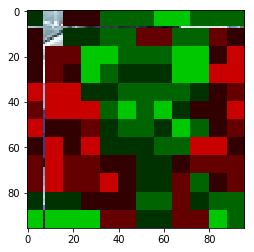

activation_4: 20


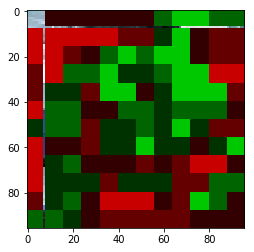

activation_6: 21


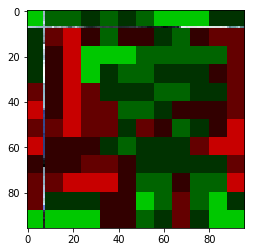

max_pooling2d_3: 22


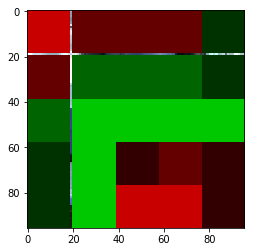

zero_padding2d_5: 23


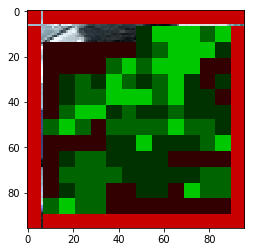

zero_padding2d_6: 24


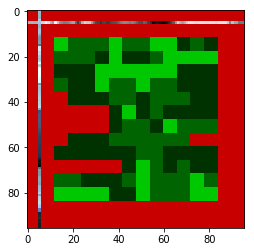

inception_3a_pool_conv: 25


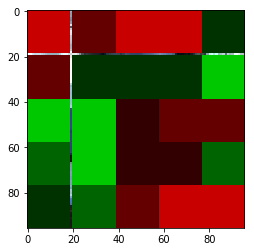

inception_3a_3x3_conv2: 26


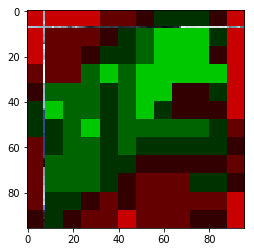

inception_3a_5x5_conv2: 27


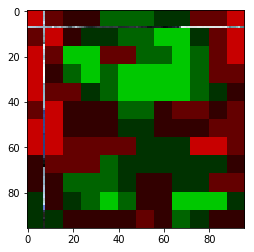

inception_3a_pool_bn: 28


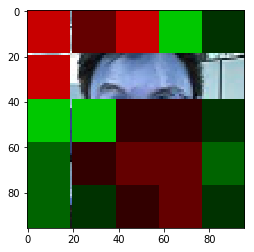

inception_3a_1x1_conv: 29


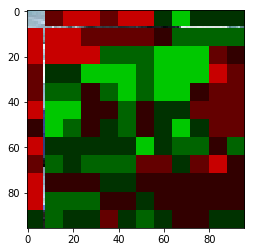

inception_3a_3x3_bn2: 30


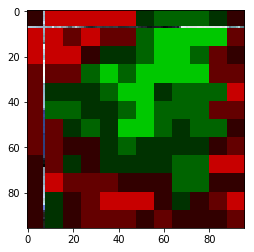

inception_3a_5x5_bn2: 31


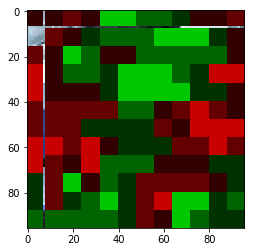

activation_8: 32


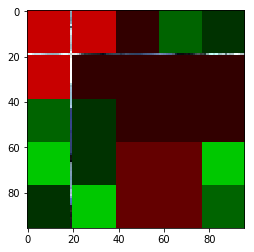

inception_3a_1x1_bn: 33


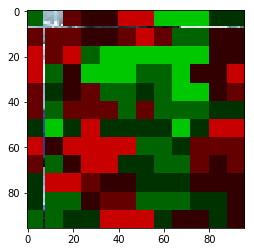

activation_5: 34


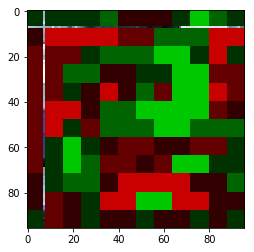

activation_7: 35


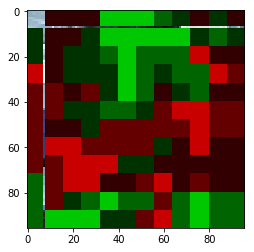

zero_padding2d_7: 36


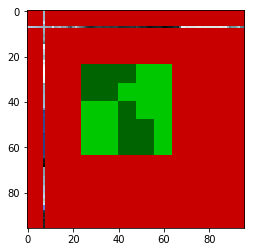

activation_9: 37


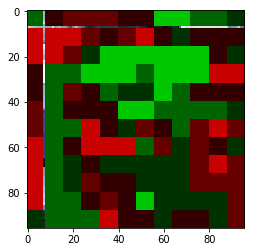

inception_1a: 38


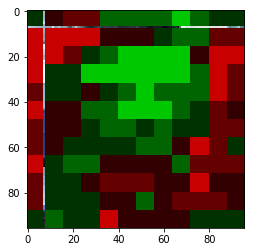

inception_3b_3x3_conv1: 39


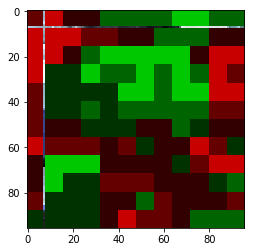

inception_3b_5x5_conv1: 40


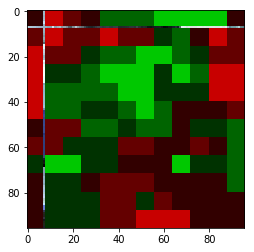

inception_3b_3x3_bn1: 41


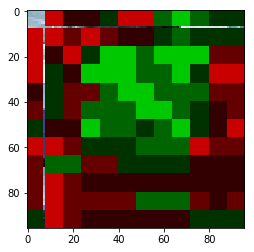

inception_3b_5x5_bn1: 42


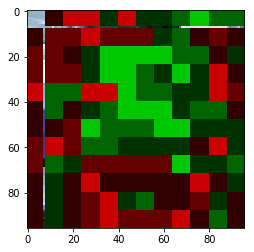

activation_10: 43


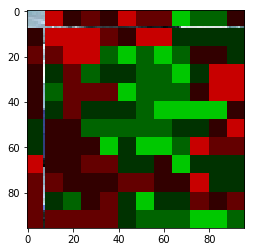

activation_12: 44


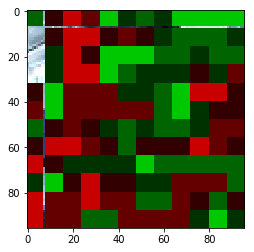

average_pooling2d_1: 45


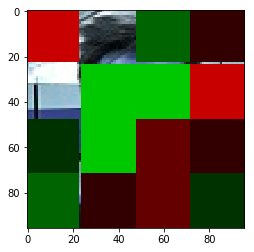

zero_padding2d_8: 46


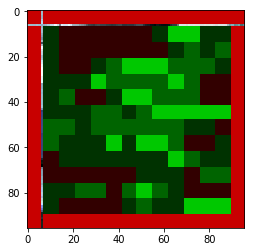

zero_padding2d_9: 47


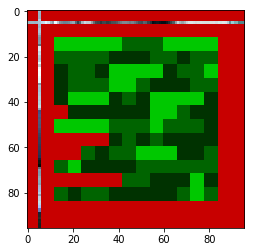

inception_3b_pool_conv: 48


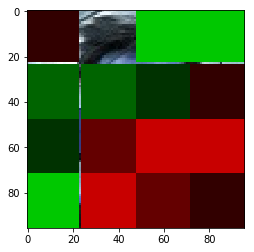

inception_3b_3x3_conv2: 49


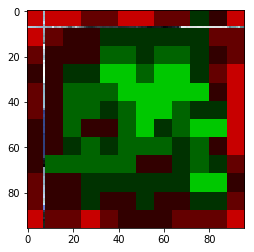

inception_3b_5x5_conv2: 50


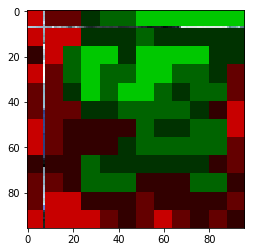

inception_3b_pool_bn: 51


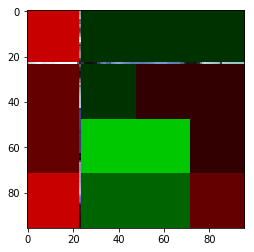

inception_3b_1x1_conv: 52


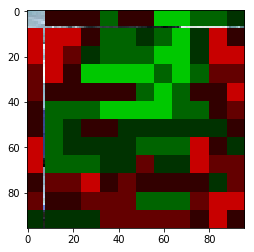

inception_3b_3x3_bn2: 53


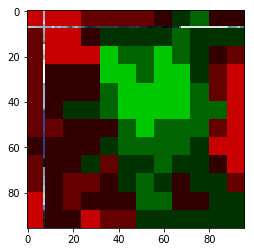

inception_3b_5x5_bn2: 54


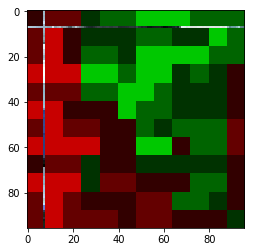

activation_14: 55


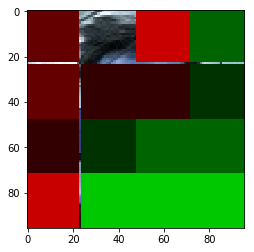

inception_3b_1x1_bn: 56


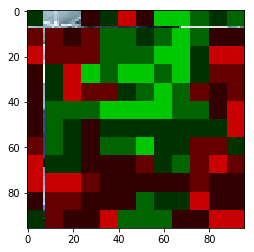

activation_11: 57


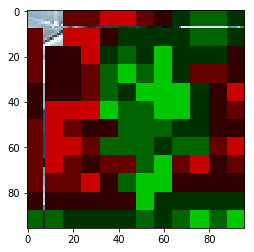

activation_13: 58


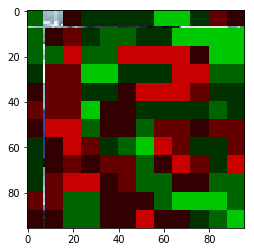

zero_padding2d_10: 59


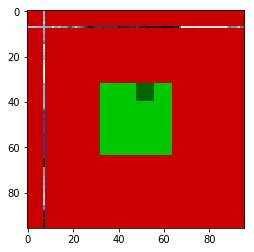

activation_15: 60


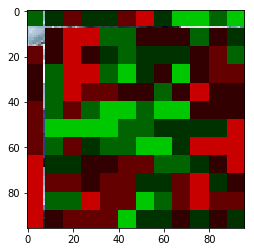

inception_1b: 61


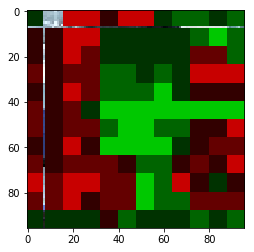

inception_3c_3x3_conv1: 62


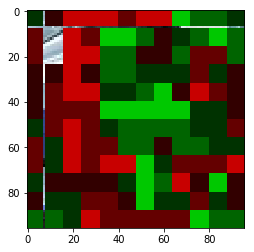

inception_3c_5x5_conv1: 63


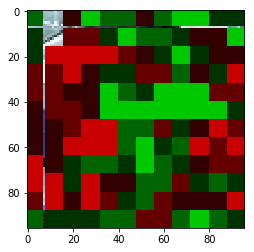

inception_3c_3x3_bn1: 64


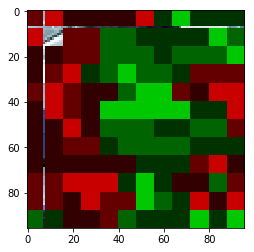

inception_3c_5x5_bn1: 65


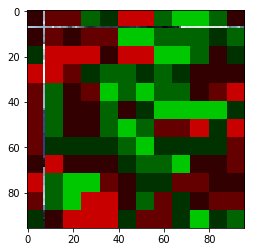

activation_16: 66


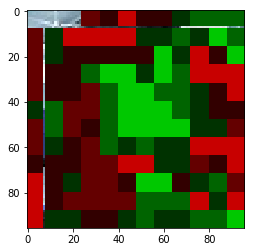

activation_18: 67


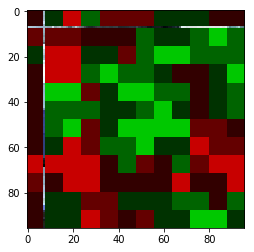

zero_padding2d_11: 68


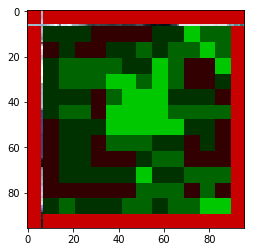

zero_padding2d_12: 69


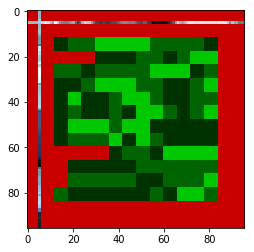

inception_3c_3x3_conv2: 70


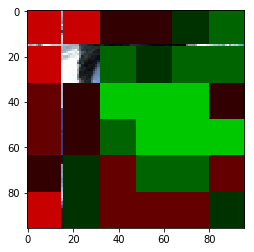

inception_3c_5x5_conv2: 71


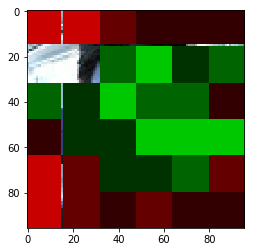

inception_3c_3x3_bn2: 72


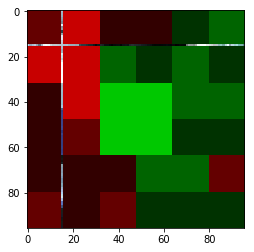

inception_3c_5x5_bn2: 73


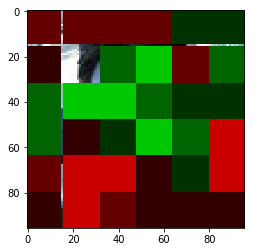

max_pooling2d_4: 74


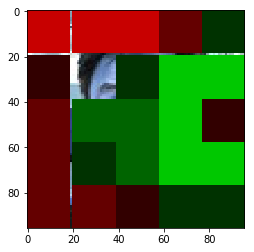

activation_17: 75


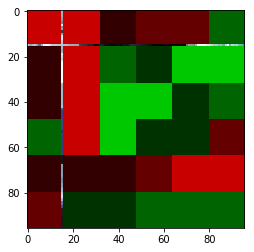

activation_19: 76


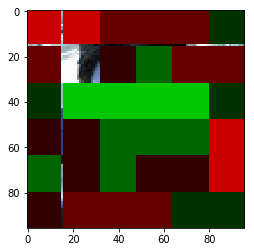

zero_padding2d_13: 77


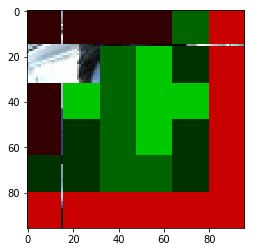

inception_1c: 78


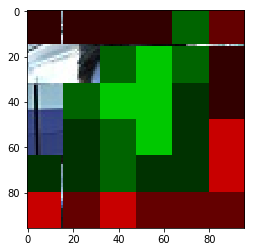

inception_4a_3x3_conv1: 79


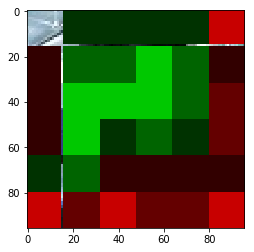

inception_4a_5x5_conv1: 80


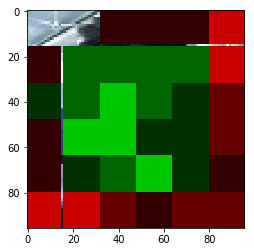

inception_4a_3x3_bn1: 81


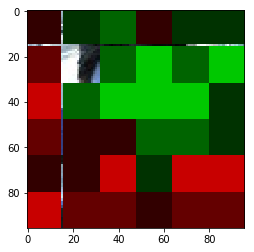

inception_4a_5x5_bn1: 82


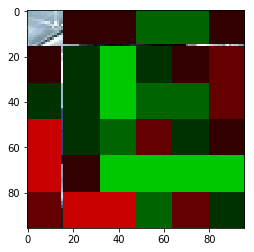

activation_20: 83


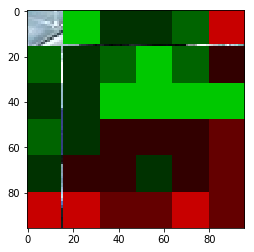

activation_22: 84


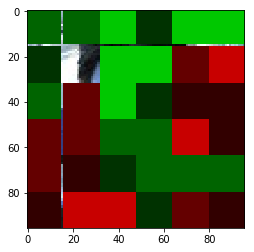

average_pooling2d_2: 85


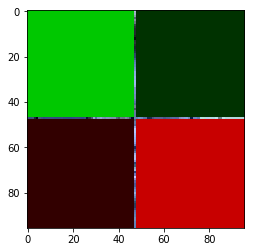

zero_padding2d_14: 86


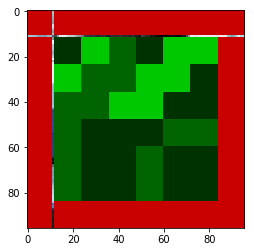

zero_padding2d_15: 87


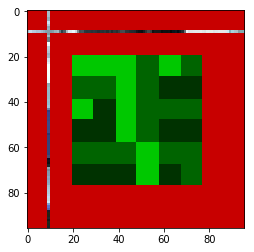

inception_4a_pool_conv: 88


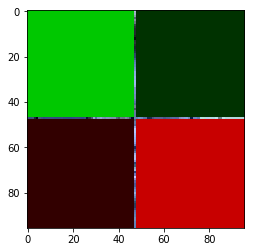

inception_4a_3x3_conv2: 89


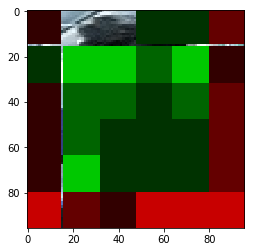

inception_4a_5x5_conv2: 90


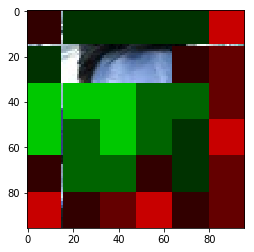

inception_4a_pool_bn: 91


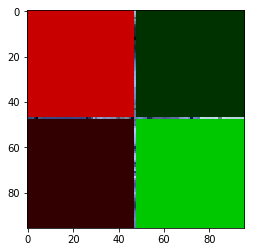

inception_4a_1x1_conv: 92


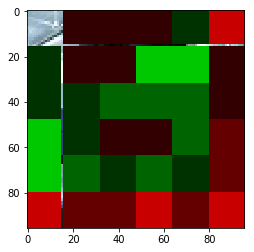

inception_4a_3x3_bn2: 93


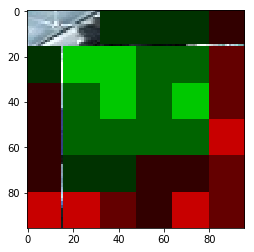

inception_4a_5x5_bn2: 94


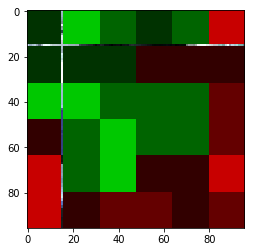

activation_24: 95


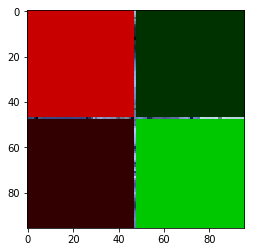

inception_4a_1x1_bn: 96


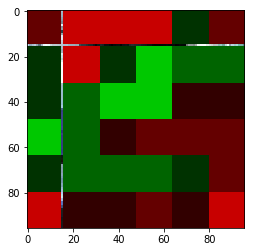

activation_21: 97


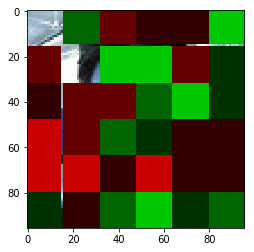

activation_23: 98


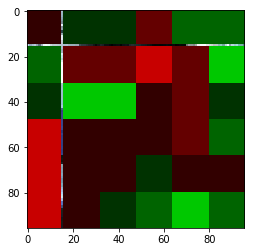

zero_padding2d_16: 99


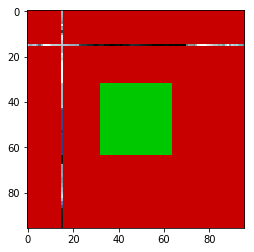

activation_25: 100


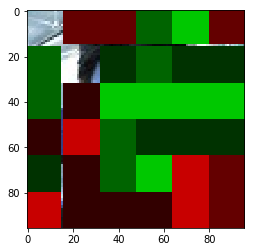

inception_2a: 101


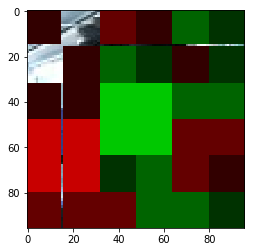

inception_4e_3x3_conv1: 102


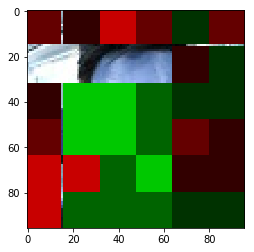

inception_4e_5x5_conv1: 103


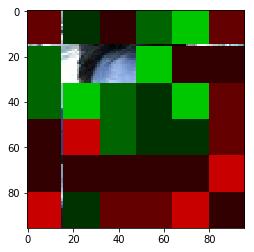

inception_4e_3x3_bn1: 104


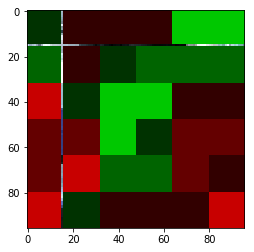

inception_4e_5x5_bn1: 105


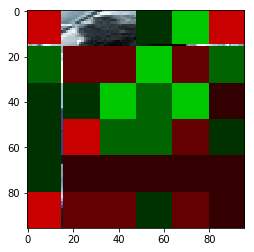

activation_26: 106


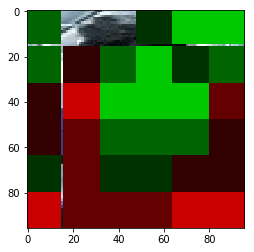

activation_28: 107


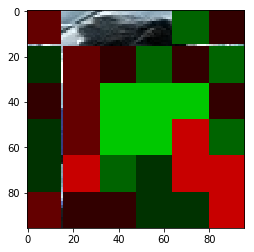

zero_padding2d_17: 108


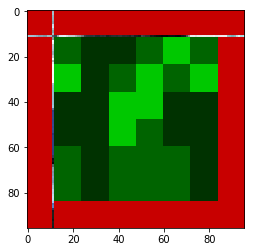

zero_padding2d_18: 109


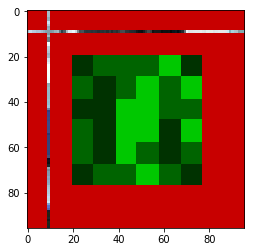

inception_4e_3x3_conv2: 110


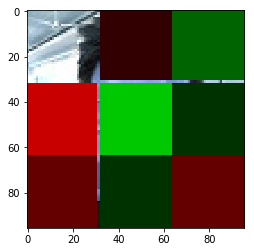

inception_4e_5x5_conv2: 111


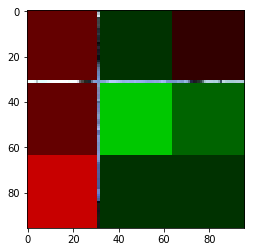

inception_4e_3x3_bn2: 112


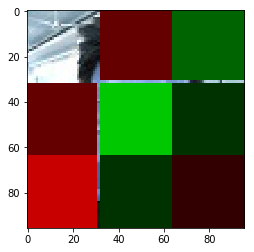

inception_4e_5x5_bn2: 113


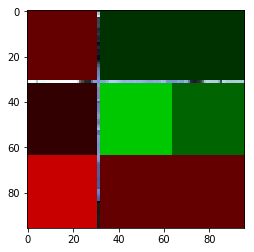

max_pooling2d_5: 114


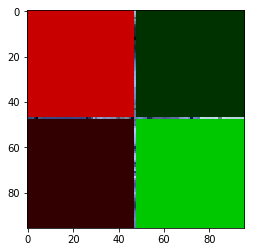

activation_27: 115


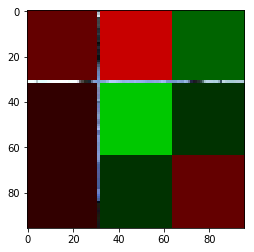

activation_29: 116


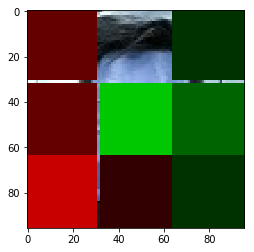

zero_padding2d_19: 117


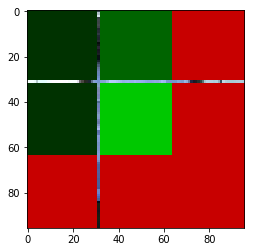

inception_2b: 118


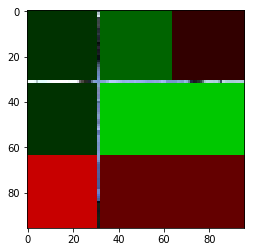

inception_5a_3x3_conv1: 119


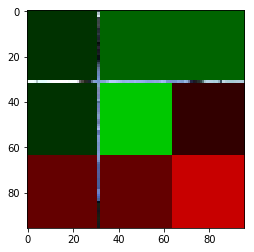

inception_5a_3x3_bn1: 120


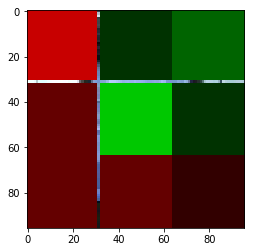

activation_30: 121


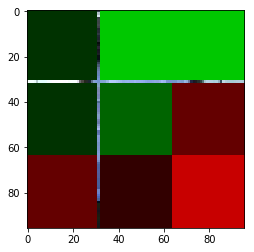

average_pooling2d_3: 122


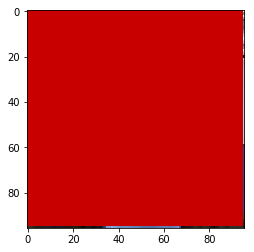

zero_padding2d_20: 123


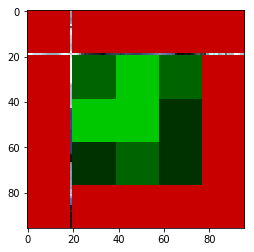

inception_5a_pool_conv: 124


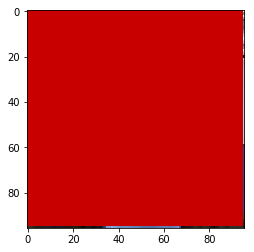

inception_5a_3x3_conv2: 125


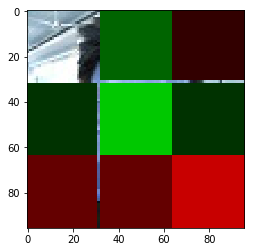

inception_5a_pool_bn: 126


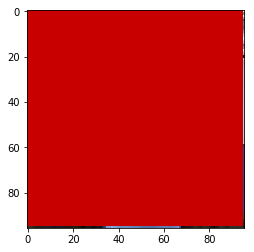

inception_5a_1x1_conv: 127


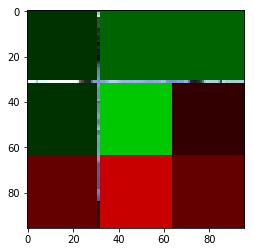

inception_5a_3x3_bn2: 128


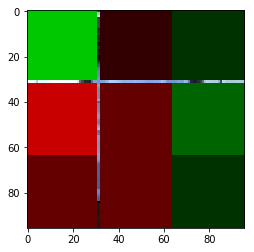

activation_32: 129


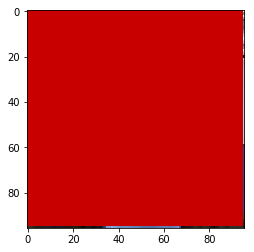

inception_5a_1x1_bn: 130


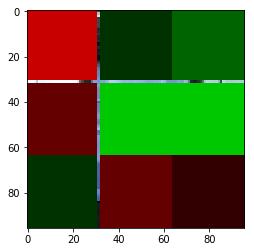

activation_31: 131


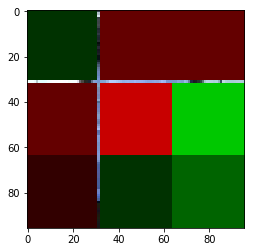

zero_padding2d_21: 132


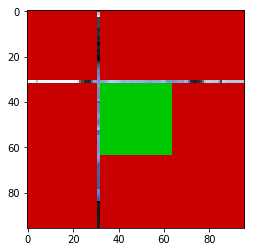

activation_33: 133


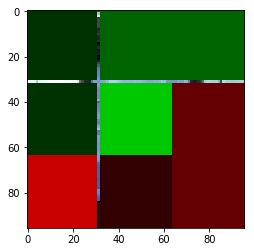

inception_3a: 134


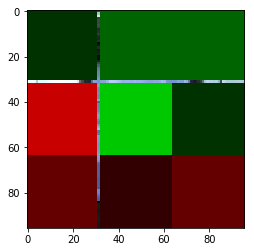

inception_5b_3x3_conv1: 135


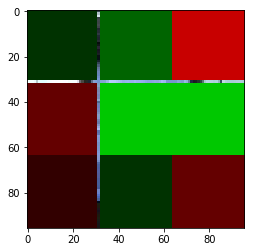

inception_5b_3x3_bn1: 136


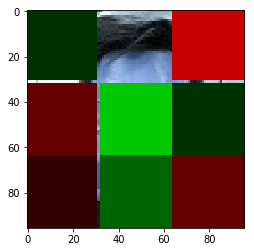

activation_34: 137


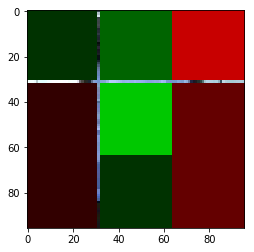

max_pooling2d_6: 138


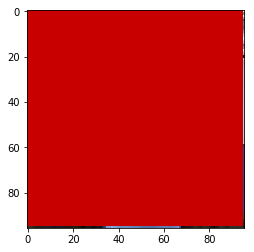

zero_padding2d_22: 139


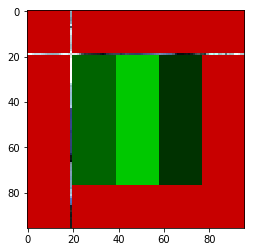

inception_5b_pool_conv: 140


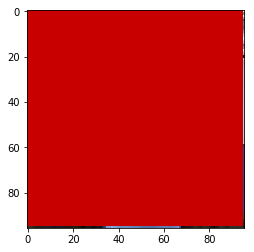

inception_5b_3x3_conv2: 141


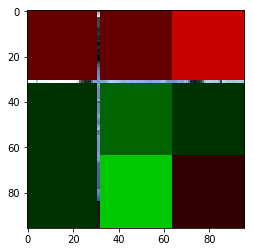

inception_5b_pool_bn: 142


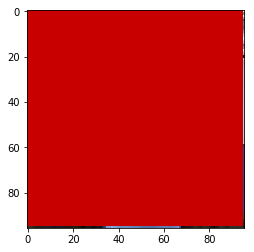

inception_5b_1x1_conv: 143


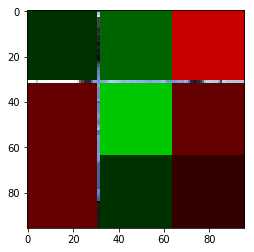

inception_5b_3x3_bn2: 144


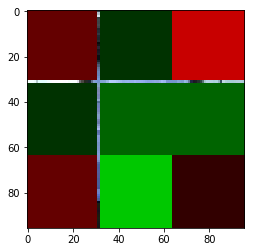

activation_36: 145


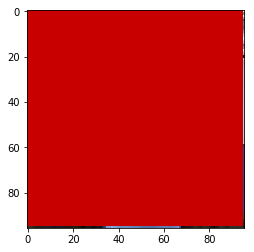

inception_5b_1x1_bn: 146


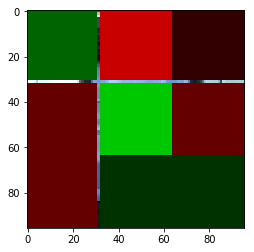

activation_35: 147


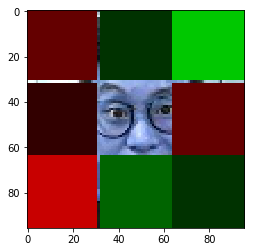

zero_padding2d_23: 148


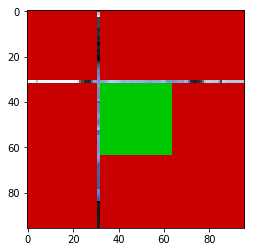

activation_37: 149


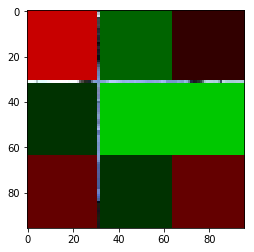

inception_3b: 150


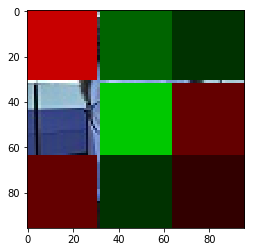

average_pooling2d_4: 151


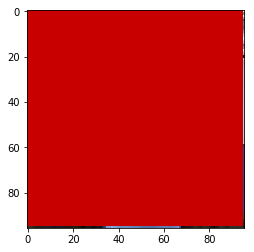

In [104]:
iterate_through_layers_dot("images/greg_positive.jpg", "images/maxim_anchor.jpg")

In [98]:
def show_certain_outputs(positive_image_path, anchor_image_path, layer_list):
    for i in layer_list:
        
        difference_matrix = compare_two_faces(positive_image_path, anchor_image_path, i)
        anchor_matrix, positive_matrix = overlay_difference_colors(positive_image_path, anchor_image_path, difference_matrix)
        
        img = Image.fromarray(anchor_matrix)
        plt.figure()
        plt.imshow(img)
        print(FRmodel.layers[i].name +": " + str(i))
        plt.show()

In [ ]:
greg_v_greg_list = [2, 3, 4, 5, 18]

In [ ]:
greg_v_maxim_list = [2, 3, 4, 5, 23, 27, 50, 54, 69]

In [ ]:
show_certain_outputs("images/greg_positive.jpg", "images/greg_anchor.jpg", greg_v_greg_list)

In [ ]:
show_certain_outputs("images/greg_positive.jpg", "images/maxim_anchor.jpg", greg_v_maxim_list)